# Loading and pre-processing data

In [2]:
# import packages
import math as m
import statistics
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os
import shutil
from statsmodels.formula.api import ols

# To get untruncated output from pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


#### Getting directories ####

# os.chdir('..' + '/Jettan/') # run this if Gamanjunni is already set

# Jettan
Jettan_dir = os.path.normpath(os.getcwd())
print('Jettan dir :', Jettan_dir)
os.chdir(Jettan_dir)

# Gamanjunni
os.chdir('..' + '/Gamanjunni/')
Gaman_dir = os.path.normpath(os.getcwd())
print('Gamanjunni dir :', Gaman_dir)

Jettan dir : C:\Users\andregas\UiO Dropbox\Andreas Aspaas\PhD_local\PhD_work\Dataanalysis_project\MonitoringData\Jettan
Gamanjunni dir : C:\Users\andregas\UiO Dropbox\Andreas Aspaas\PhD_local\PhD_work\Dataanalysis_project\MonitoringData\Gamanjunni


In [34]:
os.getcwd()

'C:\\Users\\andregas\\UiO Dropbox\\Andreas Aspaas\\PhD_local\\PhD_work\\Dataanalysis_project\\MonitoringData\\Gamanjunni'

In [16]:
os.chdir('../Jettan') # If I messed up by double running above section

## Borehole data

In [4]:
### functions to preprosess data
def remove_un_wanted_headers(dataframe):   
    mask = dataframe['Date:']!='Date:' # removing unwanted headers
    return dataframe[mask]

# datetime format changes in files
def clean_time(timeElement):
    if '.' in timeElement[:-5]:                                     
        cleanedTime = re.sub('[.]','/', timeElement) + ':00'
    if '/' in timeElement:
        cleanedTime = re.sub('[.]',':', timeElement) + ':00'
    return pd.to_datetime(cleanedTime, format='%d/%m/%Y %H:%M:%S')

def aggregate_data(file):       # setting dtype=object to remove warning, should make read_csv faster
    df = pd.read_csv(
        file, 
        sep='\t',
        decimal=",", 
        index_col=False,
        na_values=["(null)", "Totale"],
        dtype=object,
        encoding='unicode_escape',
    )
    df = remove_un_wanted_headers(df)
    # # set datetime to be index of df and remove date col as it is now index
    df.index = df['Date:'].apply(lambda x: clean_time(x))
    # # remove date col as it is now index
    df = df.drop(columns=["Date:"])
    # # drop columns only containing nans
    # empty_cols = df.isnull().sum() == df.shape[0] # old version that did not work on JTT2_wp_03
    empty_cols = df.isnull().sum() > (len(df)/4)*3 # more than 3/4th of df
    df = df.drop(columns=empty_cols.index[empty_cols.values]) 
    # drop nan values
    df = df.dropna()
    # assert nummeric type for all values
    for col in df.columns:
        df[col] = pd.to_numeric(df[col].apply(lambda x: x.replace(",", ".") if isinstance(x, str) else x))
    return df

def save_name(file):
    splittedName = file.split('\\')
    lastName = splittedName[-1]
    lastName = lastName[:-3] + 'csv'
    saveName = folder_name + lastName  # saveName = 'pre_processed_data\\'+ lastName
    return saveName

def save_concat_name(file):
    file = file[:-4]
    splittedName = file.split('\\')
    fileName = splittedName[-1]
    fileName = fileName.split('_')
    nameFirst = fileName[0]
    nameSecond = fileName[1]
    fileName = nameFirst + '_' + nameSecond + '.csv'
    saveName = folder_name + fileName #  saveName = 'processed_data\\' + fileName
    return saveName    

def save_concat_name_north_east(file):
    file = file[:-4]
    splittedName = file.split('\\')
    fileName = splittedName[-1]
    fileName = fileName.split('_')
    nameFirst = fileName[0]
    nameSecond = fileName[1]
    if nameSecond == 'disp': 
        nameThird = fileName[2]
        fileName = nameFirst + '_' + nameSecond + '_' + nameThird + '.csv'
    else:
        fileName = nameFirst + '_' + nameSecond + '.csv'
    saveName = folder_name + fileName # 'processed_data\\' + fileName
    return saveName 

def sub_sample_df(df, modules): # insert dataframe and mask for dataframe
    moduleMask = df['Module ID:'].isin([modules])
    df = df[moduleMask]
    df.set_index('Date:', drop=True, inplace=True)
    df = df.resample('1h').median()    
    
    # inclinometers
    if 'Displacement [mm]:' in df.columns:
        subSample = df[['Displacement [mm]:']]
    
    # piezometers
    if 'Water table [m bgl]:' in df.columns:
        subSample = df[['Water table [m bgl]:']]
    return subSample

def sma(data, window_size=3):
    window_size = window_size

    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []

    # Loop through the array to consider every window
    while i < len(data) - window_size + 1:

        # Calculate the average of current window
        window_average = round(np.sum(data[i:i+window_size]) / window_size, 2)

        # Store the average of current window in moving average list
        moving_averages.append(window_average)

        # Shift window to right by one position
        i += 1
    return moving_averages

# NOISE FILTERING, LOW-PASS FILTERING (BUTTERFILTER)
from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    data = data.values # values to filter
    nyq = 0.5 * fs # Nyquist Frequency, assumes regular time intervals
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low')
    y = filtfilt(b, a, data)
    return y

def magnitude(row):
    return (row[0]**2+row[1]**2)**(1/2) # sqrt(east^2+north^2) calculating magnitude of disp for each module

# def azimuth(row): # row[1] is north row[2] is east
#     degrees_offset = 0
#     sign = 1
#     if row[0] < 0:
#         if row[1] < 0:
#             degrees_offset = 180
#         else:
#             sign = -1
#     elif row[0] > 0:
#         if row[1] < 0:
#             degrees_offset = 180
#             sign = -1
#     if row[0] == 0 and row[1] == 0:
#         return 0
#     return (sign * m.degrees(m.atan2(abs(row[0]),abs(row[1])))+degrees_offset)+90 # bearings version of degrees

def azimuth(row): # new version from chatgpt that explaines that it is better than my previous as arctan2 solves all the quadrant logic I tried to do correctly
    # row[0] is north, row[1] is east
    north = row[0]
    east = row[1]
    
    # Calculate the angle in radians, converting to degrees and adjusting to compass bearing
    angle_degrees = np.degrees(np.arctan2(east, north))
    
    # Normalize to [0, 360] degrees
    if angle_degrees < 0:
        angle_degrees += 360
    
    return angle_degrees

### North and east files

In [6]:
# Quick fix for missing data borheoles when getting data from Italy in 1000nds of csv's

# NEED TO MANUALLY CHANGE NAME TO 00 for the first 9 files to get them in correct order.

folder_name = 'JTT2_temp_data\\'
if os.path.exists(folder_name):
    shutil.rmtree(folder_name)
os.mkdir(folder_name)

directions= ['000', '090']

for i in directions:
    modules = glob.glob(f'JTT2_data/{i}/*')
    modules.sort() # get ascending order
    main_df = pd.DataFrame()
    for k in modules:
        current_df = pd.read_csv(k, sep='\t', encoding='unicode_escape')
        # fixing italian column names
        current_df.reset_index(inplace=True)
        current_df.drop(columns='Accelerazione [mm/h2]:', inplace=True)
        current_df.rename(columns={'index':'Date:','Data:':'Module ID:', 'Modulo:':'Displacement [mm]:', 'Spostamento [mm] :':'Velocity [mm/h]:', 'Velocità [mm/h]:':'Acceleration [mm/h2]:'}, inplace=True)
        # concatinating all modules into one file
        main_df = pd.concat([main_df, current_df]).drop_duplicates()
    main_df.to_csv(f'{folder_name}/JTT2_disp_{i}_01.txt', sep='\t', index=False, header=True)

In [31]:
### load, processing, and save files to processed folder

# # setting main dir
# os.chdir(Jettan_dir)

# creating folder and deleting previous processed data
bhNames = glob.glob('JTT2_temp_data/*')

# # creating folder and deleting previous processed data
folder_name = 'temp_data\\'
if os.path.exists(folder_name) == True:
    shutil.rmtree(folder_name)
os.mkdir(folder_name)

newData = []

print('Loading and pre-processing files:')
for i in bhNames:
    print_name = i.split('\\')
    print(f'{print_name[-1]}')
    newData = aggregate_data(i)
    saveName = save_name(i)
    newData.to_csv(saveName, sep='\t', index = True, index_label="Date:", header=True)

    
### load, concatinate, and save files to processed_data folder
bhNames = glob.glob('temp_data/*')

# # # creating folder and deleting previous processed data
folder_name = 'temp_processed_data\\'
if os.path.exists(folder_name) == True:
    shutil.rmtree(folder_name)
os.mkdir(folder_name)

# making dictionary
my_dict = {}

for file_name in bhNames:
    parts = file_name.split('_')
    ending = parts[-1]
    start = ('_').join(parts[:-1])
    if start in my_dict.keys():
        my_dict[start].append(ending)
    else:
        my_dict[start] = [ending]

# iterating by dictionary and concatinating files

print('Concatinating files:')
for root_name in my_dict.keys():
    print_name = root_name.split('\\')
    print(f'{print_name[-1]}')
    main_df = pd.DataFrame()
    partitions = my_dict[root_name]
    for part in partitions:
        current_file_path = root_name + '_' + part
        current_df = pd.read_csv(current_file_path, sep='\t')
        main_df = pd.concat([main_df, current_df]).drop_duplicates()
    saveName = save_concat_name_north_east(current_file_path)
    main_df.to_csv(saveName, sep='\t', index=False, header=True)
print('Pre-processing finished')

# Now move on to do entire dataset

Loading and pre-processing files:
JTT2_disp_000_01.txt
JTT2_disp_000_02.txt
JTT2_disp_000_03.txt
JTT2_disp_090_01.txt
JTT2_disp_090_02.txt
JTT2_disp_090_03.txt
JTT2_wp_01.txt
JTT2_wp_02.txt
JTT2_wp_03.txt
Concatinating files:
JTT2_disp_000
JTT2_disp_090
JTT2_wp
Pre-processing finished


In [17]:
os.chdir(Jettan_dir)
os.getcwd()
# bhNames

'C:\\Users\\andregas\\UiO Dropbox\\Andreas Aspaas\\PhD_local\\PhD_work\\Dataanalysis_project\\MonitoringData\\Gamanjunni'

In [6]:
### load, processing, and save files to processed folder

# setting main dir
os.chdir(Jettan_dir)

# creating folder and deleting previous processed data
bhNames = glob.glob('borehole_north_east/*')
# bhNames = glob.glob('test/*')

# # creating folder and deleting previous processed data
folder_name = 'temp_data\\'

# # if os.path.exists(folder_name):
# shutil.rmtree(folder_name, ignore_errors=True) # dirty fix, somehow I am not able to make it work in another way

# shutil.rmtree(folder_name, ignore_errors=True)
# os.mkdir(folder_name)

# os.chdir(folder_name)

newData = []

print('Loading and pre-processing files:')
for i in bhNames:
    print_name = i.split('\\')
    print(f'{print_name[-1]}')
    newData = aggregate_data(i)
    saveName = save_name(i)
    newData.to_csv(saveName, sep='\t', index = True, index_label="Date:", header=True)
    
### load, concatinate, and save files to processed_data folder
bhNames = glob.glob('temp_data/*')

# # # creating folder and deleting previous processed data
folder_name = 'temp_processed_data\\'

# if os.path.exists(folder_name):
shutil.rmtree(folder_name, ignore_errors=True)
shutil.rmtree(folder_name, ignore_errors=True)
os.mkdir(folder_name)

# os.chdir(folder_name)

# making dictionary
my_dict = {}

for file_name in bhNames:
    parts = file_name.split('_')
    ending = parts[-1]
    start = ('_').join(parts[:-1])
    if start in my_dict.keys():
        my_dict[start].append(ending)
    else:
        my_dict[start] = [ending]

# iterating by dictionary and concatinating files

print('Concatinating files:')
for root_name in my_dict.keys():
    print_name = root_name.split('\\')
    print(f'{print_name[-1]}')
    main_df = pd.DataFrame()
    partitions = my_dict[root_name]
    for part in partitions:
        current_file_path = root_name + '_' + part
        current_df = pd.read_csv(current_file_path, sep='\t')
        main_df = pd.concat([main_df, current_df]).drop_duplicates()
    saveName = save_concat_name_north_east(current_file_path)
    main_df.to_csv(saveName, sep='\t', index=False, header=True)
print('Pre-processing finished')

#### something wrong with magnitude and azimuth calculation ####
# Therefore running it in separate cell

Loading and pre-processing files:
JTT1_disp_000_01.txt
JTT1_disp_000_02.txt
JTT1_disp_000_03.txt
JTT1_disp_000_04.txt
JTT1_disp_090_01.txt
JTT1_disp_090_02.txt
JTT1_disp_090_03.txt
JTT1_disp_090_04.txt
JTT1_wp_01.txt
JTT1_wp_02.txt
JTT1_wp_03.txt
JTT2_disp_000_01.txt
JTT2_disp_000_02.txt
JTT2_disp_000_03.txt
JTT2_disp_000_04.txt
JTT2_disp_090_01.txt
JTT2_disp_090_02.txt
JTT2_disp_090_03.txt
JTT2_disp_090_04.txt
JTT2_wp_01.txt
JTT2_wp_02.txt
JTT2_wp_03.txt
JTT3_disp_000_01.txt
JTT3_disp_000_02.txt
JTT3_disp_000_03.txt
JTT3_disp_000_04.txt
JTT3_disp_090_01.txt
JTT3_disp_090_02.txt
JTT3_disp_090_03.txt
JTT3_disp_090_04.txt
JTT3_wp_01.txt
JTT3_wp_02.txt
JTT3_wp_03.txt
Concatinating files:
JTT1_disp_000
JTT1_disp_090
JTT1_wp
JTT2_disp_000
JTT2_disp_090
JTT2_wp
JTT3_disp_000
JTT3_disp_090
JTT3_wp
Pre-processing finished


### Magnitude and azimuth

In [7]:
# low pass filter input
n = 1 # number of days cut off
fs = 1 # sample rate in hours 
cutoff = 1/(24*n) # 1/24 means cutoff at 1 day, but times nyquist frequncey so twice
order = 2 # line from 1 to 0, second order is perfect function

#######

# setting dir
os.chdir(Jettan_dir)
folder_name = 'temp_processed_data\\' 
bhNames = glob.glob(f'{folder_name}/*')
old_folder_name = folder_name

# creating folder and deleting previous processed data
folder_name = 'processed_data\\'
# # if os.path.exists(folder_name):
# shutil.rmtree(folder_name, ignore_errors=True)
# shutil.rmtree(folder_name, ignore_errors=True)
# os.mkdir(folder_name)

# making dictionary
my_dict = {}

for file_name in bhNames:
    parts = file_name.split('_')
    ending = parts[-1]
    start = ('_').join(parts[:-1])
    if start in my_dict.keys():
        my_dict[start].append(ending)
    else:
        my_dict[start] = [ending]

# iterating by dictionary and concatinating modules into two lists before merging them in one df to calculate magnitude and azimuth
print('Calculating magnitude and azimuth of each module in file:')
for root_name in my_dict.keys(): # borehole level
    print_name = root_name.split('\\')
    if len(print_name[-1]) > 7: # targeting only displacement
        saveName = f'{print_name[-1]}'
        print(saveName) # printing which borehole I am at
        main_df = pd.DataFrame()
        partitions = my_dict[root_name]
        df_north = []
        df_east = []
        valid_mod = []
        for part in partitions:
            if part == '000.csv': # north
                current_file_path = root_name + '_' + part
                df = pd.read_csv(current_file_path, sep='\t')
                df['Date:'] = pd.to_datetime(df['Date:'], format='%Y-%m-%d %H:%M:%S')
                modules = df['Module ID:'].unique()
                for i, module in enumerate(modules):
                    if i == 0:
                        file = sub_sample_df(df, module)
                        ## Filtering data by low pass filter
                        # file['disp_interpolated'] = file.iloc[:,0].interpolate(method='linear', limit_direction ='forward')
                        # file['displacement_butterfilt'] = butter_lowpass_filter(file.iloc[:,1], cutoff, fs, order)
                        # file = file.dropna().reindex(file.index) # remove interpolated rows from df
                        # file.drop(file.iloc[:, 0:2].columns, axis=1, inplace=True) # dropping columns
                        check= file # saving for next iteration
                    if i > 0:
                        file = sub_sample_df(df, module)
                        if file.last_valid_index() > check.last_valid_index(): # check if difference in length of df is equal
                            print(f'{i} north is an old module')
                        if file.last_valid_index() < check.last_valid_index(): # check if difference in length of df is equal
                            print(f'{i} north is an old module')
                        else:
                            ## Filtering data by low pass filter
                            # file['disp_interpolated'] = file.iloc[:,0].interpolate(method='linear', limit_direction ='forward')
                            # file['displacement_butterfilt'] = butter_lowpass_filter(file.iloc[:,1], cutoff, fs, order)
                            # file = file.dropna().reindex(file.index) # remove interpolated rows from df
                            # file.drop(file.iloc[:, 0:2].columns, axis=1, inplace=True) # dropping columns
                            check = file # saving for next iteration
                    df_north.append(check) # making list with all modules
            elif part == '090.csv': # east
                current_file_path = root_name + '_' + part
                df = pd.read_csv(current_file_path, sep='\t')
                df['Date:'] = pd.to_datetime(df['Date:'], format='%Y-%m-%d %H:%M:%S')
                modules = df['Module ID:'].unique()
                for i, module in enumerate(modules):
                    if i == 0:
                        file = sub_sample_df(df, module)
                        ## Filtering data by low pass filter
                        # file['disp_interpolated'] = file.iloc[:,0].interpolate(method='linear', limit_direction ='forward')
                        # file['displacement_butterfilt'] = butter_lowpass_filter(file.iloc[:,1], cutoff, fs, order)
                        # file = file.dropna().reindex(file.index) # remove interpolated rows from df
                        # file.drop(file.iloc[:, 0:2].columns, axis=1, inplace=True) # dropping columns
                        check= file # saving for next iteration
                        valid_mod.append(module) # for next calculation
                    if i > 0:
                        file = sub_sample_df(df, module)
                        if file.last_valid_index() > check.last_valid_index(): # check if difference in length of df is equal
                            print(f'{i} east is an old module')
                        if file.last_valid_index() < check.last_valid_index(): # check if difference in length of df is equal
                            print(f'{i} east is an old module')
                        else:
                            ## Filtering data by low pass filter
                            # file['disp_interpolated'] = file.iloc[:,0].interpolate(method='linear', limit_direction ='forward')
                            # file['displacement_butterfilt'] = butter_lowpass_filter(file.iloc[:,1], cutoff, fs, order)
                            # file = file.dropna().reindex(file.index) # remove interpolated rows from df
                            # file.drop(file.iloc[:, 0:2].columns, axis=1, inplace=True) # dropping columns
                            check = file # saving for next iteration
                            valid_mod.append(module) # for next calculation
                    df_east.append(file)
            
    # calculating per module from df_north and df_east
    df_list = []
    print('skipping old modules')
    for j, k in enumerate(valid_mod):
        df = pd.merge_asof(df_north[j],df_east[j], on=df_north[j].index.name, tolerance=pd.Timedelta(hours=0)) # one df
        df.set_index('Date:', inplace=True) # keeping dates
        df = df.dropna().reindex(df.index) # to make sure that both north and east direction is calculated for same timestep

        mod = [k] * len(df.index) # make module number same length as df
        magn = df.apply(magnitude, axis=1) # calculating magnitude for each row
        azi = df.apply(azimuth, axis=1) # calculating azimuth for each row

        # saving variables for each module
        current_df = pd.DataFrame(
            {'Module ID:': mod,
             'North_disp': df_north[j].iloc[:,0].values,
             'East_disp': df_east[j].iloc[:,0].values,
             'Displacement [mm]:': magn.values, # this is low pass filtered
             'Azimuth': azi.values     # this was mathematical direction, added +90 in code to make it compass direction
            }, index=df.index)
        df_list.append(current_df)
        
    # concatinating the df's for all modules to one df
    df = pd.concat(df_list, axis=0) # fixed data with magnitude and azimuth for each module
    df.reset_index(inplace=True)
    # saving
    df.to_csv(folder_name+saveName+'.csv', sep='\t', index=False, header=True)

# moving wp files to processed data
for file_name in bhNames:
    file_name = file_name.split('\\')[-1]
    if 'wp' in file_name:
        shutil.copyfile(f'{old_folder_name}\\{file_name}', f'{folder_name}\\{file_name}') # correct code?

### keep these folder as backup if this cell operation fails ### if working fine, uncomment to delete temporary folders
# shutil.rmtree('temp_data\\', ignore_errors=True)
# shutil.rmtree('temp_data\\', ignore_errors=True)
# shutil.rmtree('temp_processed_data\\', ignore_errors=True) 
# shutil.rmtree('temp_processed_data\\', ignore_errors=True)

print('pre processing data finished')

Calculating magnitude and azimuth of each module in file:
JTT1_disp
skipping old modules
skipping old modules
JTT2_disp
skipping old modules
skipping old modules
JTT3_disp
99 north is an old module
99 east is an old module
skipping old modules
skipping old modules
pre processing data finished


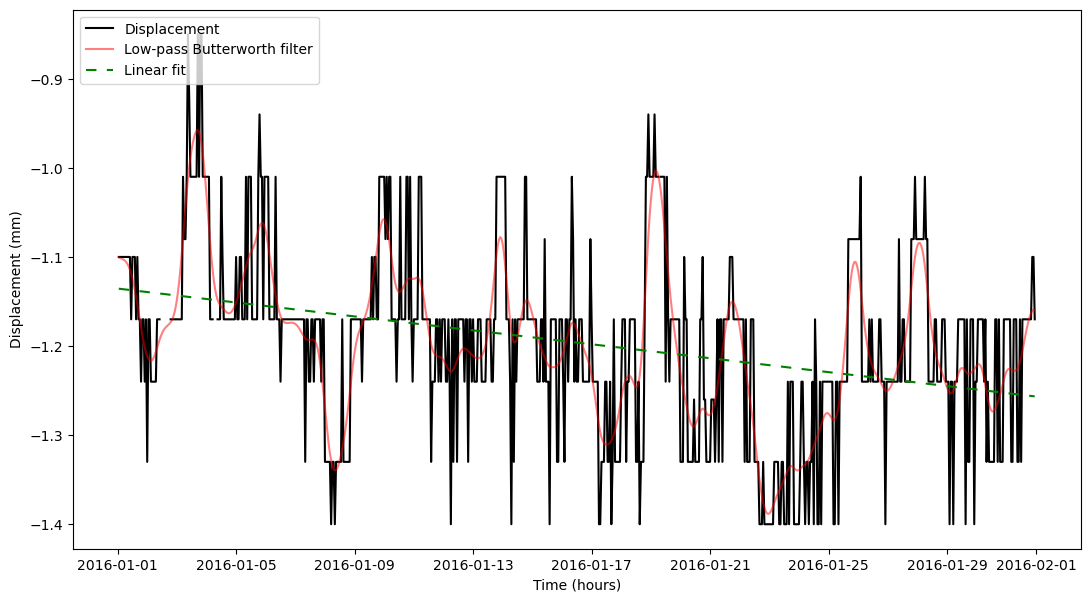

In [90]:
# concluding that the butterworth filter is not influenced by short term fluctuations (noise)

from statsmodels.graphics.regressionplots import abline_plot
from fractions import Fraction

# for the function
n = 1 # number of days cut off
fs = 1 # sample rate in hours 
cutoff = 1/(24*n) # 1/24 means cutoff at 1 day, but times nyquist frequncey so twice
order = 2 # line from 1 to 0, second order is perfect function

#### Data #####
df = JTT1Disp_e.copy()
module = 74 # module number 
file = sub_sample_df(df, module)
file['disp_interpolated'] = file.iloc[:,0].interpolate(method='linear', limit_direction ='forward')
################

file['displacement_butterfilt'] = butter_lowpass_filter(file.loc[:,'disp_interpolated'], cutoff, fs, order) # EMA (lowpass filter)

# plotting                               
df = file.copy()
plot_df = df[((df.index > pd.Timestamp('2016-01-01')) & (df.index < pd.Timestamp('2016-02-01')))]
plot_df_reg = plot_df.reset_index()

mod = ols(formula = 'displacement_butterfilt ~ plot_df_reg.index', data = plot_df_reg) # model
fit = mod.fit() # model fit
regline = fit.params[0] + fit.params[1] * plot_df_reg.index

fig, ax = plt.subplots(figsize=(13,7))
ax.plot(plot_df.index, plot_df.iloc[:,0], color='k', label='Displacement')
ax.plot(plot_df.index, plot_df.iloc[:,2], color='r', label='Low-pass Butterworth filter', alpha=0.5)
                               
# sns.lineplot(x=plot_df.index, y=fit.fittedvalues, color='g', linestyle = (0,(5, 5)), ax=ax, label='linear fit' )
# abline_plot(model_results=mod.fit(), ax=ax)
ax.plot(plot_df.index, regline, color='g', linestyle = (0,(5, 5)),label='Linear fit' )

# text boxes
# ax.text(pd.Timestamp('2021-03-01'), 37.95, f'fs = {fs} \ncutoff = 1/24 \norder = {order}', horizontalalignment='left', size='medium', color='r', fontsize=medium_size)
# ax.text(pd.Timestamp('2021-03-12'), 37.56, f'Average slope {fit.params[1]*24:.3f} mm/day \nY = {fit.params[0]:.3f} + {fit.params[1]:.3f} * X', horizontalalignment='left', size='medium', color='green', fontsize=large_size)
# ax.text(pd.Timestamp('2021-03-13'), 22.12, f'Y = {fit.params[0]:.3f} + {fit.params[1]:.3f} * X', horizontalalignment='left', size='medium', color='green', fontsize=medium_size)

ax.set_xlabel('Time (hours)')
ax.set_ylabel('Displacement (mm)')
ax.legend(loc='upper left') # fontsize=medium_size
plt.show()
# # saving
# path = 'plots\\'
# save_name = f'{path}validation_butterfilt_kh0118_cummulatedmodules.png'
# fig.savefig(save_name, dpi=300, bbox_inches='tight')

## Seismic data

In [9]:
# surface geophone array
seismicity = glob.glob('seismicity_catalogues_new/*')
seismicity = seismicity[4:] # import from 2010 and onwards

# aggregate from list to dataframe
def aggregate_data(file):
    new_data = pd.read_csv(file,sep='\t') #tab separated    ! might have stopped working due to changes to aggregate_data above!
    return new_data

all_data = []

for i in seismicity:
    new_data = aggregate_data(i)
    all_data.append(new_data)

aknes_seismicity = pd.DataFrame()

for n in all_data:
    new_data = n
    aknes_seismicity = pd.concat([aknes_seismicity, new_data], sort='Date')
    
# change date to datetime
aknes_seismicity['Date'] = pd.to_datetime(aknes_seismicity['Date'], format='%Y/%m/%dT%H:%M:%S').dt.tz_localize(None)
#save file
aknes_seismicity.to_csv('processed_data\\seismicity_new.csv', sep='\t', index = False, header=True)

# borehole seismometers
# this is manual detections by Nadege I also have the seismic energy so I could plot that?
seismicity_bh = glob.glob('seismicity_borehole/*')

all_data = []

for i in seismicity_bh:
    new_data = aggregate_data(i)
    all_data.append(new_data)

seismicity = pd.DataFrame()

for n in all_data:
    new_data = n
    seismicity = pd.concat([seismicity, new_data], sort='Time')
    
# change date to datetime and setting column location to first column 
seismicity['Time'] = pd.to_datetime(seismicity['Time'], format='%Y/%m/%dT%H:%M:%S').dt.tz_localize(None)
first_col = seismicity.pop('Time')
seismicity.insert(0,'Time', first_col)

#save file
seismicity.to_csv('processed_data\\seismicity_borehole.csv', sep='\t', index = False, header=True)

ValueError: The 'sort' keyword only accepts boolean values; Date was passed.

# Both Jettan and Gamanjunni data

## Extensometer data

In [34]:
directories = [Gaman_dir, Jettan_dir]
for i in directories:
    path = i
    file_name = 'EXT'
    df = pd.read_csv(f'{path}\\{file_name}.csv',sep=',', decimal='.',index_col=False)

    # change date to datetime
    df['_time'] = pd.to_datetime(df['_time']).dt.tz_localize(None)
    df.rename(columns={'_time': 'time'}, inplace=True)

    #save file
    df.to_csv(f'{path}\\processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

## Laser data

In [38]:
directories = [Gaman_dir, Jettan_dir]
for i in directories:
    path = i
    file_name = 'LAS'
    df = pd.read_csv(f'{path}\\{file_name}.csv',sep=',', decimal='.',index_col=False)

    # change date to datetime
    df['_time'] = pd.to_datetime(df['_time']).dt.tz_localize(None)
    df.rename(columns={'_time': 'time'}, inplace=True)

    #save file
    df.to_csv(f'{path}\\processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

## GPS data

In [4]:
directories = [Gaman_dir, Jettan_dir]
for i in directories:
    path = i
    file_name = 'GNSS_12H'
    df = pd.read_csv(f'{path}\\{file_name}.csv',sep=',', decimal='.',index_col=False)
    # if Jettan_dir in i:
    #     file_name = 'GNSS_12H_2'
    #     df2 = pd.read_csv(f'{i}\\{file_name}.csv',sep=',', decimal='.',index_col=False)
    #     df = pd.merge(df, df2, on='_time', how='outer') # merge these two datasets as I for some reason did not get the same data this time..   
    # change date to datetime
    df['_time'] = pd.to_datetime(df['_time']).dt.tz_localize(None)
    df.rename(columns={'_time': 'time'}, inplace=True)

    #save file
    df.to_csv(f'{path}\\processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

In [10]:
df.head()

,time,dE: JT_GPS_002,dE: JT_GPS_003,dE: JT_GPS_004,dE: JT_GPS_005,dE: JT_GPS_006,dE: JT_GPS_007,dE: JT_GPS_008,dE: JT_GPS_009,dE: JT_GPS_010,dE: JT_GPS_011,dH: JT_GPS_002,dH: JT_GPS_003,dH: JT_GPS_004,dH: JT_GPS_005,dH: JT_GPS_006,dH: JT_GPS_007,dH: JT_GPS_008,dH: JT_GPS_009,dH: JT_GPS_010,dH: JT_GPS_011,dN: JT_GPS_002,dN: JT_GPS_003,dN: JT_GPS_004,dN: JT_GPS_005,dN: JT_GPS_006,dN: JT_GPS_007,dN: JT_GPS_008,dN: JT_GPS_009,dN: JT_GPS_010,dN: JT_GPS_011
0,2010-02-03 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,NaN
1,2010-02-03 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.75,9.24,5.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.95,-6.09,-10.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20,1.32,1.75,NaN
2,2010-02-04 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,5.71,7.26,3.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-12.16,-6.39,-14.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.59,-1.26,-0.12,NaN
3,2010-02-04 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,4.01,6.78,5.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.39,-2.60,-9.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.55,-0.87,-2.19,NaN
4,2010-02-05 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,3.21,4.33,3.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.52,3.62,-2.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.30,-4.27,-1.62,NaN


## Meteorologic Data

In [62]:
directories = [Gaman_dir, Jettan_dir]
for i in directories:
    file_name = 'Temp'
    df = pd.read_csv(f'{i}\\{file_name}.csv',sep=',', decimal='.',index_col=False)
    if Jettan_dir in i:
        file_name = 'CLM2_temp_rain_jtt'
        df2 = pd.read_csv(f'{i}\\{file_name}.csv',sep=',', decimal='.',index_col=False)
        df = pd.merge(df, df2, on='_time', how='outer') # merge these two datasets as I for some reason did not get the same data this time..
        df.iloc[:,1] = df.iloc[:,1].fillna(df.iloc[:,2])
        df = df.drop(df.columns[2:4], axis=1) # remove unwanted columns
    df['_time'] = pd.to_datetime(df['_time']).dt.tz_localize(None)
    df.rename(columns={'_time': 'datetime'}, inplace=True)
    df.columns.values[1] = 'temperature'
    
    #save file
    file_name = 'Temp'
    df.to_csv(f'{i}\\processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

In [70]:
df.head()

,datetime,temperature
0,2014-05-22 11:00:00,0.14
1,2014-05-22 12:00:00,0.32
2,2014-05-22 13:00:00,0.24
3,2014-05-22 14:00:00,0.82
4,2014-05-22 15:00:00,1.46


In [9]:
# Need to fix this as do not know if I have it for Gamanjunni and currently script for temp..

# directories = [Gaman_dir, Jettan_dir]
# for i in directories:
i = Jettan_dir # fix when fixed Gamanjunni
file_name = 'CLM1_rain'
df = pd.read_csv(f'{i}\\{file_name}.csv',sep=',', decimal='.',index_col=False)
if Jettan_dir in i:
    file_name = 'CLM2_rain'
    df2 = pd.read_csv(f'{i}\\{file_name}.csv',sep=',', decimal='.',index_col=False)
    df = pd.merge(df, df2, on='_time', how='outer') # merge these two datasets as I for some reason did not get the same data this time..
    df.iloc[:,1] = df.iloc[:,1].fillna(df.iloc[:,2])
    df = df.drop(df.columns[2], axis=1)
df['_time'] = pd.to_datetime(df['_time']).dt.tz_localize(None)
df.rename(columns={'_time': 'datetime'}, inplace=True)
df.columns.values[1] = 'precip'

#save file
file_name = 'Precip'
df.to_csv(f'{i}\\processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

In [53]:
# directories = [Gaman_dir, Jettan_dir]
# for i in directories:
i = Gaman_dir # fix when fixed Gamanjunni
file_name = 'Precip'
df = pd.read_csv(f'{i}\\{file_name}.csv',sep=',', decimal='.',index_col=False)
df['_time'] = pd.to_datetime(df['_time']).dt.tz_localize(None)
df.rename(columns={'_time': 'datetime'}, inplace=True)
df = df.drop(df.columns[1], axis=1)
df.columns.values[1] = 'precip'

#save file
file_name = 'Precip'
df.to_csv(f'{i}\\processed_data\\{file_name}.csv',sep='\t', index = False, header=True)
df.head()

,datetime,precip
0,2017-10-09 14:00:00,0.0
1,2017-10-09 15:00:00,0.0
2,2017-10-09 16:00:00,0.1
3,2017-10-09 17:00:00,0.0
4,2017-10-09 18:00:00,0.0


In [43]:
i = Gaman_dir # fix when fixed Gamanjunni
file_name = 'Snow'
df = pd.read_csv(f'{i}\\{file_name}.csv',sep=',', decimal='.',index_col=False)
df['_time'] = pd.to_datetime(df['_time']).dt.tz_localize(None)
df.rename(columns={'_time': 'datetime'}, inplace=True)
df.columns.values[1] = 'depth'

#save file
file_name = 'Snow'
df.to_csv(f'{i}\\processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

In [ ]:
# Need to fix this as do not know if I have it for Gamanjunni and currently script for temp..

# directories = [Gaman_dir, Jettan_dir]
# for i in directories:
i = Jettan_dir # fix when fixed Gamanjunni
file_name = 'CLM2_groundtemp'
df = pd.read_csv(f'{i}\\{file_name}.csv',sep=',', decimal='.',index_col=False)
# if Jettan_dir in i:
#     file_name = 'CLM2_rain'
#     df2 = pd.read_csv(f'{i}\\{file_name}.csv',sep=',', decimal='.',index_col=False)
#     df = pd.merge(df, df2, on='_time', how='outer') # merge these two datasets as I for some reason did not get the same data this time..
#     df.iloc[:,1] = df.iloc[:,1].fillna(df.iloc[:,2])
#     df = df.drop(df.columns[2], axis=1)

df['_time'] = pd.to_datetime(df['_time']).dt.tz_localize(None)
df.rename(columns={'_time': 'datetime'}, inplace=True)
# df.columns.values[1] = 'precip'

#save file
file_name = 'Ground_temp'
df.to_csv(f'{i}\\processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

In [50]:
i = Gaman_dir
file_name = 'Snow_2'
df = pd.read_csv(f'{i}\\{file_name}.csv',sep=',', decimal='.',index_col=False) 
df['_time'] = pd.to_datetime(df['_time']).dt.tz_localize(None)
df.rename(columns={'_time': 'datetime'}, inplace=True)
df.columns.values[1] = 'depth_top'
df.columns.values[2] = 'depth_plateau'

#save file
file_name = 'Snow'
df.to_csv(f'{i}\\processed_data\\{file_name}.csv',sep='\t', index = False, header=True)
df.head()

,datetime,depth_top,depth_plateau
0,2017-10-09 14:00:00,4.0,NaN
1,2017-10-09 15:00:00,3.0,NaN
2,2017-10-09 16:00:00,3.0,NaN
3,2017-10-09 17:00:00,3.0,NaN
4,2017-10-09 18:00:00,3.0,NaN


In [56]:
directories = [Gaman_dir, Jettan_dir]
for i in directories:
    file_name = 'Snow'
    df = pd.read_csv(f'{i}\\{file_name}.csv',sep=',', decimal='.',index_col=False)
    if Jettan_dir in i:
        file_name = 'CLM2_snow_jtt'
        df2 = pd.read_csv(f'{i}\\{file_name}.csv',sep=',', decimal='.',index_col=False)
        df = pd.merge(df, df2, on='_time', how='outer') # merge these two datasets as I for some reason did not get the same data this time..   
    df['_time'] = pd.to_datetime(df['_time']).dt.tz_localize(None)
    df.rename(columns={'_time': 'datetime'}, inplace=True)
    # df.columns.values[1] = 'depth'

    #save file
    file_name = 'Snow'
    df.to_csv(f'{i}\\processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

### Ground temperature data

In [50]:
os.getcwd()

'C:\\Users\\andregas\\UiO Dropbox\\Andreas Aspaas\\PhD_local\\PhD_work\\Dataanalysis_project\\MonitoringData\\Jettan'

In [58]:
os.chdir(Jettan_dir)
main_df = pd.DataFrame()
files = glob.glob('Klimadata_JT_CLM_1/*')
for i in files:
    print(f'File: {i}')
    current_df = pd.read_csv(f'{i}',sep=',', decimal='.', header=1) # ,index_col=False
    main_df = pd.concat([main_df, current_df]).drop_duplicates()
main_df.drop(main_df.index[[0,1]], inplace=True)
main_df = main_df[['TIMESTAMP','FT_gr_C_Avg']] 
main_df = main_df.rename(columns={'TIMESTAMP':'datetime', 'FT_gr_C_Avg' : 'TJ_5: JT_CLM_001'})

file_name = 'CLM2_groundtemp'
df = pd.read_csv(f'{file_name}.csv',sep=',', decimal='.',index_col=False)
df['_time'] = pd.to_datetime(df['_time']).dt.tz_localize(None)
df.rename(columns={'_time': 'datetime'}, inplace=True)
df = df.iloc[:,:3] # remove snow

main_df = pd.concat([main_df, df]).drop_duplicates()
main_df.iloc[:,3] = main_df.iloc[:,3].fillna(df.iloc[:,1]) # fill nan in col3 with col1
main_df = main_df.drop(main_df.columns[1], axis=1) # drop col1
main_df.rename(columns={'TJ_5: JT_CLM_002': 'TJ_5: JT_CLM_001_002'}, inplace=True)

# saving
main_df.to_csv('processed_data\\JT_CLM_1_2.csv',sep='\t', index = False, header=True)

print('Finnished concatinating and saving files')

File: Klimadata_JT_CLM_1\CR1000_Res_data_01.dat
File: Klimadata_JT_CLM_1\CR1000_Res_data_02.dat
File: Klimadata_JT_CLM_1\CR1000_Res_data_03.dat
File: Klimadata_JT_CLM_1\CR1000_Res_data_04.dat
File: Klimadata_JT_CLM_1\CR1000_Res_data_05.dat
Finnished concatinating and saving files


In [15]:
# Tinytag from Blikra and Christiansen project
os.chdir(Jettan_dir)
df = pd.read_excel('ST1-3.xlsx', sheet_name=0,  skiprows=3, converters= {'Time': pd.to_datetime})
df = df.rename(columns={'Unnamed: 1':'datetime'})
ST = df[['datetime', 'ST3', 'ST2', 'ST1']]
df = pd.read_excel('ST2.xlsx', sheet_name=0,  skiprows=4, converters= {'Time': pd.to_datetime})
df = df.rename(columns={'Unnamed: 1':'datetime', 'Temperature' : 'ST2'})
ST2 = df[['datetime', 'ST2']]
df = pd.read_excel('ST3.xlsx', sheet_name=0,  skiprows=4, converters= {'Time': pd.to_datetime})
df = df.rename(columns={'Unnamed: 1':'datetime', 'Temperature' : 'ST3'})
ST3 = df[['datetime', 'ST3']]
current_df = pd.merge_asof(ST2, ST3, on=ST2.index.name, tolerance=pd.Timedelta(hours=0))
main_df = pd.concat([ST, current_df], axis=0)
main_df.to_csv(f'processed_data\\ST.csv', sep='\t', index = False, header=True)

C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [17]:
# tilt data for entire period, a little bit down in the east side of the back scarp
os.chdir(Jettan_dir)

file_name = 'tlt2_temp'
df = pd.read_csv(f'{file_name}.csv',sep=',', decimal='.',index_col=False)
# change date to datetime
df['_time'] = pd.to_datetime(df['_time']).dt.tz_localize(None)
df.rename(columns={'_time': 'datetime'}, inplace=True)
df.columns.values[1] = 'temperature'
#save file
df.to_csv(f'processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

file_name = 'tlt9_temp'
df = pd.read_csv(f'{file_name}.csv',sep=',', decimal='.',index_col=False)
# change date to datetime
df['_time'] = pd.to_datetime(df['_time']).dt.tz_localize(None)
df.rename(columns={'_time': 'datetime'}, inplace=True)
df.columns.values[1] = 'temperature'
#save file
df.to_csv(f'processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

file_name = 'Temp1'
df = pd.read_excel(f'{file_name}.xlsx', sheet_name=0,  skiprows=5, converters= {'Time': pd.to_datetime})
df = df.rename(columns={'Unnamed: 1':'datetime', 'Temperature':'temperature'})
df = df[['datetime', 'temperature']]
#save file
df.to_csv(f'processed_data\\{file_name}.csv',sep='\t', index = False, header=True)


main_df = pd.DataFrame()
file_name = 'Hobos'
for i in range(4):
    df = pd.read_excel(f'{file_name}.xlsx', sheet_name=i,  skiprows=1)
    df.columns.values[1] = 'datetime'
    time = df[['datetime']]
    # print(df.head())
    df = df.iloc[:,2]
    df = df.rename(f'H{i}')
    df = pd.DataFrame(df)
    main_df = pd.concat([main_df, df], axis=1) # , axis=1

main_df = pd.concat([time, main_df], axis=1)
main_df['datetime'] = pd.to_datetime(main_df['datetime'])
#save file
main_df.to_csv(f'processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
C:\Users\andregas\AppData\Local\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### Xgeo data set

In [43]:
path = Jettan_dir

In [28]:
directories = [Gaman_dir, Jettan_dir]
for i in directories:
    file_name = 'xgeo_precipitation'
    df = pd.read_csv(f'{i}\\{file_name}.csv', sep=';', decimal=',',index_col=False, header=1)
    df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')
    df = df.rename(columns={'Date':'datetime', 'rr(mm)' : 'precip'})
    df = df[['datetime', 'precip']] # keeping columns
    mask = df['datetime'] > np.datetime64('2010-01-01') # slicing on time
    df = df[mask]

    #save file
    file_name = 'xgeo_precip'
    df.to_csv(f'{i}\\processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

In [49]:
# directories

# os.chdir('../Jettan') # Jettan
os.chdir('../Gamanjunni') # Gamanjunni

print(os.getcwd()) # current dir

C:\Users\andregas\UiO Dropbox\Andreas Aspaas\PhD_local\PhD_work\Dataanalysis_project\MonitoringData\Gamanjunni


In [3]:
directories = [Gaman_dir, Jettan_dir]
for i in directories:
    file_name = 'xgeo_airtemp'
    df = pd.read_csv(f'{i}\\{file_name}.csv', sep=';', decimal=',',index_col=False, header=1)
    df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')
    df = df.rename(columns={'Date':'datetime', 'tm(Celcius)' : 'temperature'})
    df = df[['datetime', 'temperature']] # keeping columns
    mask = df['datetime'] > np.datetime64('2010-01-01') # slicing on time
    df = df[mask]

    #save file
    file_name = 'xgeo_temp'
    df.to_csv(f'{i}\\processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

In [ ]:
# New try as it messed up data the directories approach

In [69]:
os.chdir('../Gamanjunni') # Gamanjunni
print(os.getcwd()) # current dir

file_name = 'gam_xgeo_temp'
df = pd.read_csv(f'{file_name}.csv', sep=';', decimal=',',index_col=False, header=1)
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')
df = df.rename(columns={'Date':'datetime', 'tm(Celcius)' : 'temperature'})
df = df[['datetime', 'temperature']] # keeping columns
mask = df['datetime'] > np.datetime64('2010-01-01') # slicing on time
df = df[mask]
df.to_csv(f'processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

file_name = 'gam_xgeo_precip'
df = pd.read_csv(f'{file_name}.csv', sep=';', decimal=',',index_col=False, header=1)
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')
df = df.rename(columns={'Date':'datetime', 'rr(mm)' : 'precip'})
df = df[['datetime', 'precip']] # keeping columns
mask = df['datetime'] > np.datetime64('2010-01-01') # slicing on time
df = df[mask]
df.to_csv(f'processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

file_name = 'gam_xgeo_snowdepth'
df = pd.read_csv(f'{file_name}.csv', sep=';', decimal=',',index_col=False, header=1)
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')
df = df.rename(columns={'Date':'datetime', 'sd(cm)' : 'depth'})
df = df[['datetime', 'depth']] # keeping columns
mask = df['datetime'] > np.datetime64('2010-01-01') # slicing on time
df = df[mask]
df.to_csv(f'processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

file_name = 'gam_xgeo_surfacerunoff'
df = pd.read_csv(f'{file_name}.csv',sep=';', decimal=',',index_col=False, header=1)
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')
df = df.rename(columns={'Date':'datetime', 'gwb_q(mm)' : 'surfacerunoff'})
df = df[['datetime', 'surfacerunoff']] # keeping columns
mask = df['datetime'] > np.datetime64('2010-01-01') # slicing on time
df = df[mask]
df.to_csv(f'processed_data\\{file_name}.csv',sep='\t', index = False, header=True)


C:\Users\andregas\UiO Dropbox\Andreas Aspaas\PhD_local\PhD_work\Dataanalysis_project\MonitoringData\Gamanjunni


In [71]:
os.chdir('../Jettan') # Jettan
print(os.getcwd()) # current dir

file_name = 'jett_xgeo_temp'
df = pd.read_csv(f'{file_name}.csv', sep=';', decimal=',',index_col=False, header=1)
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')
df = df.rename(columns={'Date':'datetime', 'tm(Celcius)' : 'temperature'})
df = df[['datetime', 'temperature']] # keeping columns
mask = df['datetime'] > np.datetime64('2010-01-01') # slicing on time
df = df[mask]
df.to_csv(f'processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

file_name = 'jett_xgeo_precip'
df = pd.read_csv(f'{file_name}.csv', sep=';', decimal=',',index_col=False, header=1)
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')
df = df.rename(columns={'Date':'datetime', 'rr(mm)' : 'precip'})
df = df[['datetime', 'precip']] # keeping columns
mask = df['datetime'] > np.datetime64('2010-01-01') # slicing on time
df = df[mask]
df.to_csv(f'processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

file_name = 'jett_xgeo_snowdepth'
df = pd.read_csv(f'{file_name}.csv', sep=';', decimal=',',index_col=False, header=1)
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')
df = df.rename(columns={'Date':'datetime', 'sd(cm)' : 'depth'})
df = df[['datetime', 'depth']] # keeping columns
mask = df['datetime'] > np.datetime64('2010-01-01') # slicing on time
df = df[mask]
df.to_csv(f'processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

file_name = 'jett_xgeo_surfacerunoff'
df = pd.read_csv(f'{file_name}.csv',sep=';', decimal=',',index_col=False, header=1)
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')
df = df.rename(columns={'Date':'datetime', 'gwb_q(mm)' : 'surfacerunoff'})
df = df[['datetime', 'surfacerunoff']] # keeping columns
mask = df['datetime'] > np.datetime64('2010-01-01') # slicing on time
df = df[mask]
df.to_csv(f'processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

C:\Users\andregas\UiO Dropbox\Andreas Aspaas\PhD_local\PhD_work\Dataanalysis_project\MonitoringData\Jettan


In [24]:
directories = [Gaman_dir, Jettan_dir]
for i in directories:
    file_name = 'xgeo_snowdepth'
    df = pd.read_csv(f'{i}\\{file_name}.csv', sep=';', decimal=',',index_col=False, header=1)
    df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')
    df = df.rename(columns={'Date':'datetime', 'sd(cm)' : 'depth'})
    df = df[['datetime', 'depth']] # keeping columns
    mask = df['datetime'] > np.datetime64('2010-01-01') # slicing on time
    df = df[mask]

    #save file
    file_name = 'xgeo_snow'
    df.to_csv(f'{i}\\processed_data\\{file_name}.csv',sep='\t', index = False, header=True)

In [36]:
directories = [Gaman_dir, Jettan_dir]
for i in directories:
    file_name = 'xgeo_surfacerunoff'
    df = pd.read_csv(f'{i}\\{file_name}.csv',sep=';', decimal=',',index_col=False, header=1)
    df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')
    df = df.rename(columns={'Date':'datetime', 'gwb_q(mm)' : 'surfacerunoff'})
    df = df[['datetime', 'surfacerunoff']] # keeping columns
    mask = df['datetime'] > np.datetime64('2010-01-01') # slicing on time
    df = df[mask]

    #save file
    file_name = 'xgeo_surfacerunnoff'
    df.to_csv(f'{i}\\processed_data\\{file_name}.csv',sep='\t', index = False, header=True)